In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "MNIST"
ood = "5:6:7:8:9"


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

  0%|                                                                                                                                                          | 0/60000 [00:00<?, ?it/s]

 13%|█████████████████▉                                                                                                                          | 7699/60000 [00:00<00:00, 76981.26it/s]

 26%|███████████████████████████████████▊                                                                                                       | 15461/60000 [00:00<00:00, 77352.03it/s]

 39%|█████████████████████████████████████████████████████▋                                                                                     | 23197/60000 [00:00<00:00, 77032.18it/s]

 52%|████████████████████████████████████████████████████████████████████████▏                                                                  | 31150/60000 [00:00<00:00, 78011.02it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                | 39080/60000 [00:00<00:00, 78471.85it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 46928/60000 [00:00<00:00, 77602.37it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 54800/60000 [00:00<00:00, 77963.85it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 77431.07it/s]

  0%|                                                                                                                                                          | 0/10000 [00:00<?, ?it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 7864/10000 [00:00<00:00, 78638.20it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 76901.43it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

5:6:7:8:9 umry49p9


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                            | 0/192 [00:00<?, ?it/s]

  1%|▊                                                                                                                                                   | 1/192 [00:01<04:16,  1.34s/it]

  2%|██▎                                                                                                                                                 | 3/192 [00:01<01:14,  2.55it/s]

  3%|███▊                                                                                                                                                | 5/192 [00:01<00:40,  4.59it/s]

  4%|█████▍                                                                                                                                              | 7/192 [00:01<00:27,  6.75it/s]

  5%|██████▉                                                                                                                                             | 9/192 [00:01<00:20,  8.89it/s]

  6%|████████▍                                                                                                                                          | 11/192 [00:01<00:16, 10.87it/s]

  7%|█████████▉                                                                                                                                         | 13/192 [00:01<00:14, 12.60it/s]

  8%|███████████▍                                                                                                                                       | 15/192 [00:02<00:12, 14.05it/s]

  9%|█████████████                                                                                                                                      | 17/192 [00:02<00:11, 15.20it/s]

 10%|██████████████▌                                                                                                                                    | 19/192 [00:02<00:10, 16.09it/s]

 11%|████████████████                                                                                                                                   | 21/192 [00:02<00:10, 16.76it/s]

 12%|█████████████████▌                                                                                                                                 | 23/192 [00:02<00:09, 17.25it/s]

 13%|███████████████████▏                                                                                                                               | 25/192 [00:02<00:09, 17.60it/s]

 14%|████████████████████▋                                                                                                                              | 27/192 [00:02<00:09, 17.83it/s]

 15%|██████████████████████▏                                                                                                                            | 29/192 [00:02<00:09, 17.99it/s]

 16%|███████████████████████▋                                                                                                                           | 31/192 [00:02<00:08, 18.12it/s]

 17%|█████████████████████████▎                                                                                                                         | 33/192 [00:03<00:08, 18.22it/s]

 18%|██████████████████████████▊                                                                                                                        | 35/192 [00:03<00:08, 18.29it/s]

 19%|████████████████████████████▎                                                                                                                      | 37/192 [00:03<00:08, 18.33it/s]

 20%|█████████████████████████████▊                                                                                                                     | 39/192 [00:03<00:08, 18.37it/s]

 21%|███████████████████████████████▍                                                                                                                   | 41/192 [00:03<00:08, 18.41it/s]

 22%|████████████████████████████████▉                                                                                                                  | 43/192 [00:03<00:08, 18.43it/s]

 23%|██████████████████████████████████▍                                                                                                                | 45/192 [00:03<00:07, 18.45it/s]

 24%|███████████████████████████████████▉                                                                                                               | 47/192 [00:03<00:07, 18.45it/s]

 26%|█████████████████████████████████████▌                                                                                                             | 49/192 [00:03<00:07, 18.46it/s]

 27%|███████████████████████████████████████                                                                                                            | 51/192 [00:04<00:07, 18.46it/s]

 28%|████████████████████████████████████████▌                                                                                                          | 53/192 [00:04<00:07, 18.46it/s]

 29%|██████████████████████████████████████████                                                                                                         | 55/192 [00:04<00:07, 18.46it/s]

 30%|███████████████████████████████████████████▋                                                                                                       | 57/192 [00:04<00:07, 18.40it/s]

 31%|█████████████████████████████████████████████▏                                                                                                     | 59/192 [00:04<00:07, 18.39it/s]

 32%|██████████████████████████████████████████████▋                                                                                                    | 61/192 [00:04<00:07, 18.42it/s]

 33%|████████████████████████████████████████████████▏                                                                                                  | 63/192 [00:04<00:07, 18.42it/s]

 34%|█████████████████████████████████████████████████▊                                                                                                 | 65/192 [00:04<00:06, 18.43it/s]

 35%|███████████████████████████████████████████████████▎                                                                                               | 67/192 [00:04<00:06, 18.42it/s]

 36%|████████████████████████████████████████████████████▊                                                                                              | 69/192 [00:05<00:06, 18.43it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                            | 71/192 [00:05<00:06, 18.44it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                           | 73/192 [00:05<00:06, 18.45it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                         | 75/192 [00:05<00:06, 18.46it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                        | 77/192 [00:05<00:06, 18.47it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                      | 79/192 [00:05<00:06, 18.46it/s]

 42%|██████████████████████████████████████████████████████████████                                                                                     | 81/192 [00:05<00:06, 18.46it/s]

 43%|███████████████████████████████████████████████████████████████▌                                                                                   | 83/192 [00:05<00:05, 18.46it/s]

 44%|█████████████████████████████████████████████████████████████████                                                                                  | 85/192 [00:05<00:05, 18.46it/s]

 45%|██████████████████████████████████████████████████████████████████▌                                                                                | 87/192 [00:06<00:05, 18.47it/s]

 46%|████████████████████████████████████████████████████████████████████▏                                                                              | 89/192 [00:06<00:05, 18.47it/s]

 47%|█████████████████████████████████████████████████████████████████████▋                                                                             | 91/192 [00:06<00:05, 18.47it/s]

 48%|███████████████████████████████████████████████████████████████████████▏                                                                           | 93/192 [00:06<00:05, 18.48it/s]

 49%|████████████████████████████████████████████████████████████████████████▋                                                                          | 95/192 [00:06<00:05, 18.46it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                        | 97/192 [00:06<00:05, 18.47it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                       | 99/192 [00:06<00:05, 18.48it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                     | 101/192 [00:06<00:04, 18.47it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 103/192 [00:06<00:04, 18.47it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                  | 105/192 [00:06<00:04, 18.48it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                                | 107/192 [00:07<00:04, 18.46it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 109/192 [00:07<00:04, 18.46it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 111/192 [00:07<00:04, 18.47it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                            | 113/192 [00:07<00:04, 18.47it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▍                                                          | 115/192 [00:07<00:04, 18.48it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 117/192 [00:07<00:04, 18.44it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 119/192 [00:07<00:03, 18.44it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                      | 121/192 [00:07<00:03, 18.44it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 123/192 [00:07<00:03, 18.45it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████                                                   | 125/192 [00:08<00:03, 18.46it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 127/192 [00:08<00:03, 18.47it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                | 129/192 [00:08<00:03, 18.47it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 131/192 [00:08<00:03, 18.48it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 133/192 [00:08<00:03, 18.47it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 135/192 [00:08<00:03, 18.47it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 137/192 [00:08<00:02, 18.47it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 139/192 [00:08<00:02, 18.47it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 141/192 [00:08<00:02, 18.48it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 143/192 [00:09<00:02, 18.48it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 145/192 [00:09<00:02, 18.48it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 147/192 [00:09<00:02, 18.48it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 149/192 [00:09<00:02, 18.47it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 151/192 [00:09<00:02, 18.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 153/192 [00:09<00:02, 18.46it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 155/192 [00:09<00:02, 18.45it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 157/192 [00:09<00:01, 18.46it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 159/192 [00:09<00:01, 18.46it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 161/192 [00:10<00:01, 18.46it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 163/192 [00:10<00:01, 18.46it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 165/192 [00:10<00:01, 18.46it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 167/192 [00:10<00:01, 18.46it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 169/192 [00:10<00:01, 18.47it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 171/192 [00:10<00:01, 18.47it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 173/192 [00:10<00:01, 18.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 175/192 [00:10<00:00, 18.44it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 177/192 [00:10<00:00, 18.45it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 179/192 [00:10<00:00, 18.45it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 181/192 [00:11<00:00, 18.47it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 183/192 [00:11<00:00, 18.47it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 185/192 [00:11<00:00, 18.47it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 187/192 [00:11<00:00, 18.50it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 189/192 [00:11<00:00, 18.53it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 191/192 [00:11<00:00, 18.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 192/192 [00:11<00:00, 16.40it/s]

train - OK


  0%|                                                                                                                                                             | 0/48 [00:00<?, ?it/s]

  2%|███                                                                                                                                                  | 1/48 [00:00<00:06,  7.49it/s]

  6%|█████████▎                                                                                                                                           | 3/48 [00:00<00:03, 13.33it/s]

 10%|███████████████▌                                                                                                                                     | 5/48 [00:00<00:02, 15.55it/s]

 15%|█████████████████████▋                                                                                                                               | 7/48 [00:00<00:02, 16.67it/s]

 19%|███████████████████████████▉                                                                                                                         | 9/48 [00:00<00:02, 17.30it/s]

 23%|█████████████████████████████████▉                                                                                                                  | 11/48 [00:00<00:02, 17.69it/s]

 27%|████████████████████████████████████████                                                                                                            | 13/48 [00:00<00:01, 17.94it/s]

 31%|██████████████████████████████████████████████▎                                                                                                     | 15/48 [00:00<00:01, 18.11it/s]

 35%|████████████████████████████████████████████████████▍                                                                                               | 17/48 [00:01<00:01, 18.22it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                         | 19/48 [00:01<00:01, 18.29it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                   | 21/48 [00:01<00:01, 18.34it/s]

 48%|██████████████████████████████████████████████████████████████████████▉                                                                             | 23/48 [00:01<00:01, 18.38it/s]

 52%|█████████████████████████████████████████████████████████████████████████████                                                                       | 25/48 [00:01<00:01, 18.41it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                | 27/48 [00:01<00:01, 18.43it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                          | 29/48 [00:01<00:01, 18.45it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 31/48 [00:01<00:00, 18.46it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 33/48 [00:01<00:00, 18.47it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 35/48 [00:01<00:00, 18.47it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 37/48 [00:02<00:00, 18.46it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 39/48 [00:02<00:00, 18.46it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 41/48 [00:02<00:00, 18.49it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 43/48 [00:02<00:00, 18.51it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 45/48 [00:02<00:00, 18.53it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 47/48 [00:02<00:00, 18.56it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:02<00:00, 17.61it/s]

val - OK


  0%|                                                                                                                                                             | 0/41 [00:00<?, ?it/s]

  2%|███▋                                                                                                                                                 | 1/41 [00:00<00:05,  7.31it/s]

  7%|██████████▉                                                                                                                                          | 3/41 [00:00<00:02, 13.17it/s]

 12%|██████████████████▏                                                                                                                                  | 5/41 [00:00<00:02, 15.47it/s]

 17%|█████████████████████████▍                                                                                                                           | 7/41 [00:00<00:02, 16.62it/s]

 22%|████████████████████████████████▋                                                                                                                    | 9/41 [00:00<00:01, 17.29it/s]

 27%|███████████████████████████████████████▋                                                                                                            | 11/41 [00:00<00:01, 17.70it/s]

 32%|██████████████████████████████████████████████▉                                                                                                     | 13/41 [00:00<00:01, 17.97it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                             | 15/41 [00:00<00:01, 18.15it/s]

 41%|█████████████████████████████████████████████████████████████▎                                                                                      | 17/41 [00:01<00:01, 18.27it/s]

 46%|████████████████████████████████████████████████████████████████████▌                                                                               | 19/41 [00:01<00:01, 18.30it/s]

 51%|███████████████████████████████████████████████████████████████████████████▊                                                                        | 21/41 [00:01<00:01, 18.38it/s]

 56%|███████████████████████████████████████████████████████████████████████████████████                                                                 | 23/41 [00:01<00:00, 18.46it/s]

 61%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 25/41 [00:01<00:00, 18.51it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 27/41 [00:01<00:00, 18.53it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 29/41 [00:01<00:00, 18.54it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 31/41 [00:01<00:00, 18.54it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 33/41 [00:01<00:00, 18.58it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 35/41 [00:01<00:00, 18.62it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 37/41 [00:02<00:00, 18.65it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 39/41 [00:02<00:00, 18.65it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 18.95it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:02<00:00, 17.70it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/268 [00:00<?, ?it/s]

  0%|▌                                                                                                                                                   | 1/268 [00:00<00:37,  7.20it/s]

  1%|█▋                                                                                                                                                  | 3/268 [00:00<00:20, 13.07it/s]

  2%|██▊                                                                                                                                                 | 5/268 [00:00<00:17, 15.38it/s]

  3%|███▊                                                                                                                                                | 7/268 [00:00<00:15, 16.52it/s]

  3%|████▉                                                                                                                                               | 9/268 [00:00<00:15, 17.21it/s]

  4%|██████                                                                                                                                             | 11/268 [00:00<00:14, 17.63it/s]

  5%|███████▏                                                                                                                                           | 13/268 [00:00<00:14, 17.89it/s]

  6%|████████▏                                                                                                                                          | 15/268 [00:00<00:14, 18.07it/s]

  6%|█████████▎                                                                                                                                         | 17/268 [00:01<00:13, 18.19it/s]

  7%|██████████▍                                                                                                                                        | 19/268 [00:01<00:13, 18.30it/s]

  8%|███████████▌                                                                                                                                       | 21/268 [00:01<00:13, 18.35it/s]

  9%|████████████▌                                                                                                                                      | 23/268 [00:01<00:13, 18.40it/s]

  9%|█████████████▋                                                                                                                                     | 25/268 [00:01<00:13, 18.43it/s]

 10%|██████████████▊                                                                                                                                    | 27/268 [00:01<00:13, 18.44it/s]

 11%|███████████████▉                                                                                                                                   | 29/268 [00:01<00:12, 18.43it/s]

 12%|█████████████████                                                                                                                                  | 31/268 [00:01<00:12, 18.45it/s]

 12%|██████████████████                                                                                                                                 | 33/268 [00:01<00:12, 18.44it/s]

 13%|███████████████████▏                                                                                                                               | 35/268 [00:01<00:12, 18.41it/s]

 14%|████████████████████▎                                                                                                                              | 37/268 [00:02<00:12, 18.42it/s]

 15%|█████████████████████▍                                                                                                                             | 39/268 [00:02<00:12, 18.43it/s]

 15%|██████████████████████▍                                                                                                                            | 41/268 [00:02<00:12, 18.44it/s]

 16%|███████████████████████▌                                                                                                                           | 43/268 [00:02<00:12, 18.45it/s]

 17%|████████████████████████▋                                                                                                                          | 45/268 [00:02<00:12, 18.43it/s]

 18%|█████████████████████████▊                                                                                                                         | 47/268 [00:02<00:11, 18.44it/s]

 18%|██████████████████████████▉                                                                                                                        | 49/268 [00:02<00:11, 18.44it/s]

 19%|███████████████████████████▉                                                                                                                       | 51/268 [00:02<00:11, 18.46it/s]

 20%|█████████████████████████████                                                                                                                      | 53/268 [00:02<00:11, 18.46it/s]

 21%|██████████████████████████████▏                                                                                                                    | 55/268 [00:03<00:11, 18.48it/s]

 21%|███████████████████████████████▎                                                                                                                   | 57/268 [00:03<00:11, 18.47it/s]

 22%|████████████████████████████████▎                                                                                                                  | 59/268 [00:03<00:11, 18.46it/s]

 23%|█████████████████████████████████▍                                                                                                                 | 61/268 [00:03<00:11, 18.47it/s]

 24%|██████████████████████████████████▌                                                                                                                | 63/268 [00:03<00:11, 18.47it/s]

 24%|███████████████████████████████████▋                                                                                                               | 65/268 [00:03<00:10, 18.47it/s]

 25%|████████████████████████████████████▊                                                                                                              | 67/268 [00:03<00:10, 18.47it/s]

 26%|█████████████████████████████████████▊                                                                                                             | 69/268 [00:03<00:10, 18.46it/s]

 26%|██████████████████████████████████████▉                                                                                                            | 71/268 [00:03<00:10, 18.47it/s]

 27%|████████████████████████████████████████                                                                                                           | 73/268 [00:04<00:10, 18.46it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 75/268 [00:04<00:10, 18.48it/s]

 29%|██████████████████████████████████████████▏                                                                                                        | 77/268 [00:04<00:10, 18.51it/s]

 29%|███████████████████████████████████████████▎                                                                                                       | 79/268 [00:04<00:10, 18.49it/s]

 30%|████████████████████████████████████████████▍                                                                                                      | 81/268 [00:04<00:10, 18.49it/s]

 31%|█████████████████████████████████████████████▌                                                                                                     | 83/268 [00:04<00:10, 18.47it/s]

 32%|██████████████████████████████████████████████▌                                                                                                    | 85/268 [00:04<00:09, 18.49it/s]

 32%|███████████████████████████████████████████████▋                                                                                                   | 87/268 [00:04<00:09, 18.49it/s]

 33%|████████████████████████████████████████████████▊                                                                                                  | 89/268 [00:04<00:09, 18.50it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                 | 91/268 [00:05<00:09, 18.49it/s]

 35%|███████████████████████████████████████████████████                                                                                                | 93/268 [00:05<00:09, 18.49it/s]

 35%|████████████████████████████████████████████████████                                                                                               | 95/268 [00:05<00:09, 18.48it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                             | 97/268 [00:05<00:09, 18.48it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                            | 99/268 [00:05<00:09, 18.48it/s]

 38%|███████████████████████████████████████████████████████                                                                                           | 101/268 [00:05<00:09, 18.49it/s]

 38%|████████████████████████████████████████████████████████                                                                                          | 103/268 [00:05<00:08, 18.47it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 105/268 [00:05<00:08, 18.47it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                       | 107/268 [00:05<00:08, 18.44it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 109/268 [00:05<00:08, 18.46it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                     | 111/268 [00:06<00:08, 18.47it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                    | 113/268 [00:06<00:08, 18.46it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 115/268 [00:06<00:08, 18.45it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                  | 117/268 [00:06<00:08, 18.46it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                 | 119/268 [00:06<00:08, 18.46it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 121/268 [00:06<00:07, 18.44it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                               | 123/268 [00:06<00:07, 18.45it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                              | 125/268 [00:06<00:07, 18.46it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                            | 127/268 [00:06<00:07, 18.47it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 129/268 [00:07<00:07, 18.48it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                          | 131/268 [00:07<00:07, 18.48it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                         | 133/268 [00:07<00:07, 18.49it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 135/268 [00:07<00:07, 18.49it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                       | 137/268 [00:07<00:07, 18.48it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 139/268 [00:07<00:06, 18.48it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                     | 141/268 [00:07<00:06, 18.36it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                    | 143/268 [00:07<00:06, 18.39it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                   | 145/268 [00:07<00:06, 18.42it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 147/268 [00:08<00:06, 18.43it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                                | 149/268 [00:08<00:06, 18.45it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 151/268 [00:08<00:06, 18.47it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 153/268 [00:08<00:06, 18.47it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 155/268 [00:08<00:06, 18.48it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                            | 157/268 [00:08<00:06, 18.48it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 159/268 [00:08<00:05, 18.48it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                          | 161/268 [00:08<00:05, 18.47it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 163/268 [00:08<00:05, 18.49it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 165/268 [00:09<00:05, 18.48it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 167/268 [00:09<00:05, 18.48it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                      | 169/268 [00:09<00:05, 18.47it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 171/268 [00:09<00:05, 18.48it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 173/268 [00:09<00:05, 18.48it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 175/268 [00:09<00:05, 18.45it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 177/268 [00:09<00:04, 18.44it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 179/268 [00:09<00:04, 18.45it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 181/268 [00:09<00:04, 18.46it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 183/268 [00:09<00:04, 18.47it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 185/268 [00:10<00:04, 18.48it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 187/268 [00:10<00:04, 18.49it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 189/268 [00:10<00:04, 18.48it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 191/268 [00:10<00:04, 18.48it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 193/268 [00:10<00:04, 18.48it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 195/268 [00:10<00:03, 18.47it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 197/268 [00:10<00:03, 18.48it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 199/268 [00:10<00:03, 18.48it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 201/268 [00:10<00:03, 18.48it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 203/268 [00:11<00:03, 18.47it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 205/268 [00:11<00:03, 18.47it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 207/268 [00:11<00:03, 18.47it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 209/268 [00:11<00:03, 18.47it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 211/268 [00:11<00:03, 18.47it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 213/268 [00:11<00:02, 18.47it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 215/268 [00:11<00:02, 18.49it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 217/268 [00:11<00:02, 18.47it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 219/268 [00:11<00:02, 18.47it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 221/268 [00:12<00:02, 18.45it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 223/268 [00:12<00:02, 18.47it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 225/268 [00:12<00:02, 18.45it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 227/268 [00:12<00:02, 18.47it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 229/268 [00:12<00:02, 18.49it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 231/268 [00:12<00:02, 18.49it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 233/268 [00:12<00:01, 18.48it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 235/268 [00:12<00:01, 18.48it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 237/268 [00:12<00:01, 18.46it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 239/268 [00:13<00:01, 18.46it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 241/268 [00:13<00:01, 18.46it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 243/268 [00:13<00:01, 18.47it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 245/268 [00:13<00:01, 18.46it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 247/268 [00:13<00:01, 18.47it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 249/268 [00:13<00:01, 18.45it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 251/268 [00:13<00:00, 18.47it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 253/268 [00:13<00:00, 18.48it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 255/268 [00:13<00:00, 18.50it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 257/268 [00:14<00:00, 18.50it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 259/268 [00:14<00:00, 18.50it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 261/268 [00:14<00:00, 18.54it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 263/268 [00:14<00:00, 18.55it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 265/268 [00:14<00:00, 18.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 267/268 [00:14<00:00, 18.55it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 268/268 [00:14<00:00, 18.31it/s]

test OoD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  3%|████▍                                                                                                                                               | 3/100 [00:00<00:04, 21.23it/s]

  6%|████████▉                                                                                                                                           | 6/100 [00:00<00:04, 21.29it/s]

  9%|█████████████▎                                                                                                                                      | 9/100 [00:00<00:04, 21.31it/s]

 12%|█████████████████▋                                                                                                                                 | 12/100 [00:00<00:04, 21.30it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:00<00:03, 21.32it/s]

 18%|██████████████████████████▍                                                                                                                        | 18/100 [00:00<00:03, 21.33it/s]

 21%|██████████████████████████████▊                                                                                                                    | 21/100 [00:00<00:03, 21.34it/s]

 24%|███████████████████████████████████▎                                                                                                               | 24/100 [00:01<00:03, 21.35it/s]

 27%|███████████████████████████████████████▋                                                                                                           | 27/100 [00:01<00:03, 21.35it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:01<00:03, 21.35it/s]

 33%|████████████████████████████████████████████████▌                                                                                                  | 33/100 [00:01<00:03, 21.35it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 36/100 [00:01<00:02, 21.36it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 39/100 [00:01<00:02, 21.36it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 42/100 [00:01<00:02, 21.37it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:02<00:02, 21.36it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:02<00:02, 21.36it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 51/100 [00:02<00:02, 21.35it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 54/100 [00:02<00:02, 21.35it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 57/100 [00:02<00:02, 21.35it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:02<00:01, 21.35it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 63/100 [00:02<00:01, 21.35it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 66/100 [00:03<00:01, 21.34it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 69/100 [00:03<00:01, 21.36it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 72/100 [00:03<00:01, 21.37it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:03<00:01, 21.36it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/100 [00:03<00:01, 21.36it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 81/100 [00:03<00:00, 21.36it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 84/100 [00:03<00:00, 21.36it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 87/100 [00:04<00:00, 21.36it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:04<00:00, 21.36it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 93/100 [00:04<00:00, 21.35it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:04<00:00, 21.35it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:04<00:00, 21.36it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.35it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(24476, 1, 32, 32) (24476, 256) (24476, 768) (24476, 1, 32, 32) (24476,)
(6120, 1, 32, 32) (6120, 256) (6120, 768) (6120, 1, 32, 32) (6120,)
(5139, 1, 32, 32) (5139, 256) (5139, 768) (5139, 1, 32, 32) (5139,)
(34265, 1, 32, 32) (34265, 256) (34265, 768) (34265, 1, 32, 32) (34265,)
(12800, 1, 32, 32) (12800, 256) (12800, 768) (12800, 1, 32, 32)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5139, 2) (34265, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(5139, 2) (34265, 2)


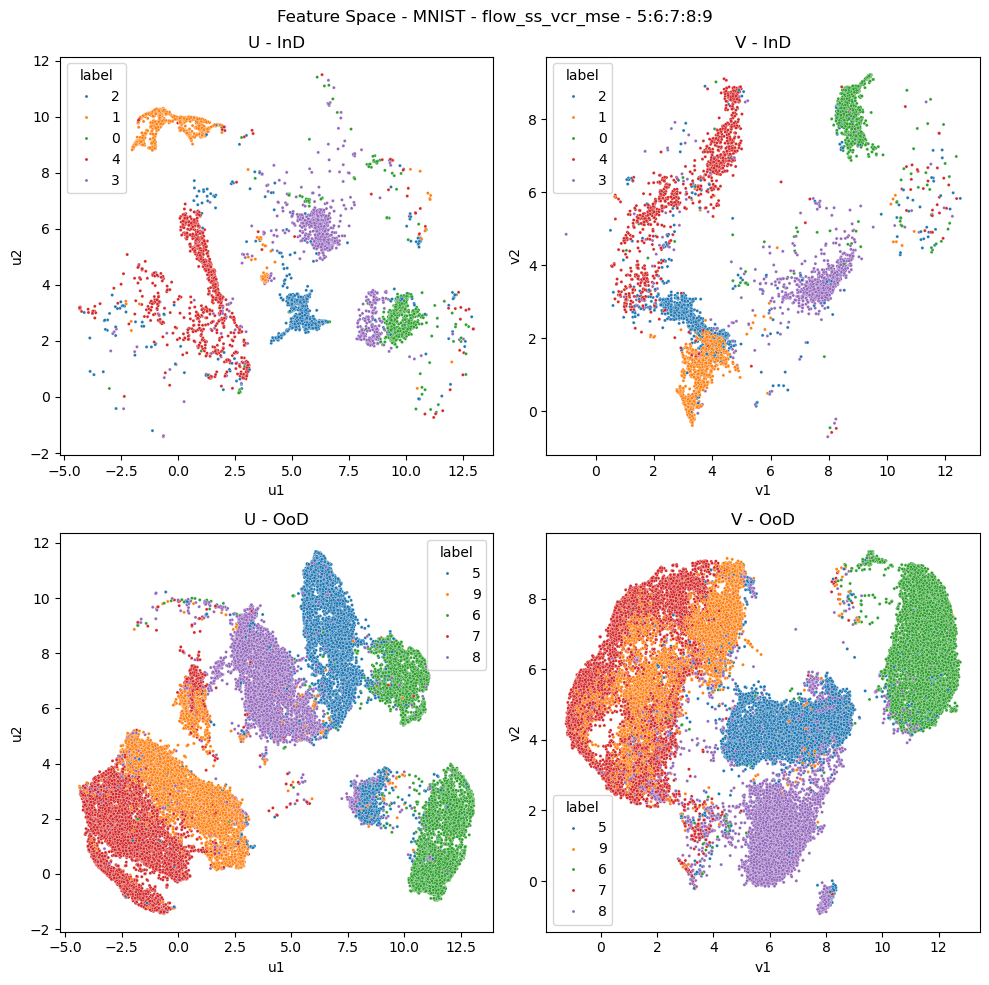

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

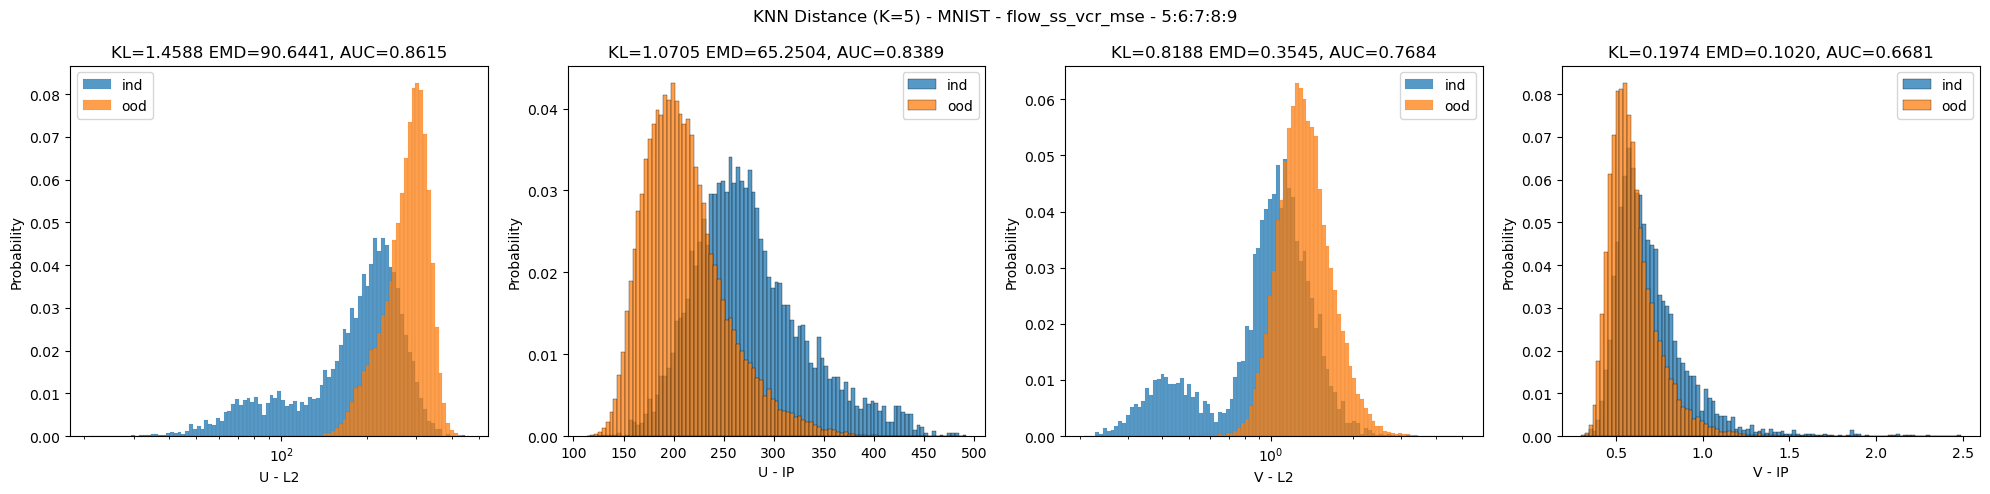

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

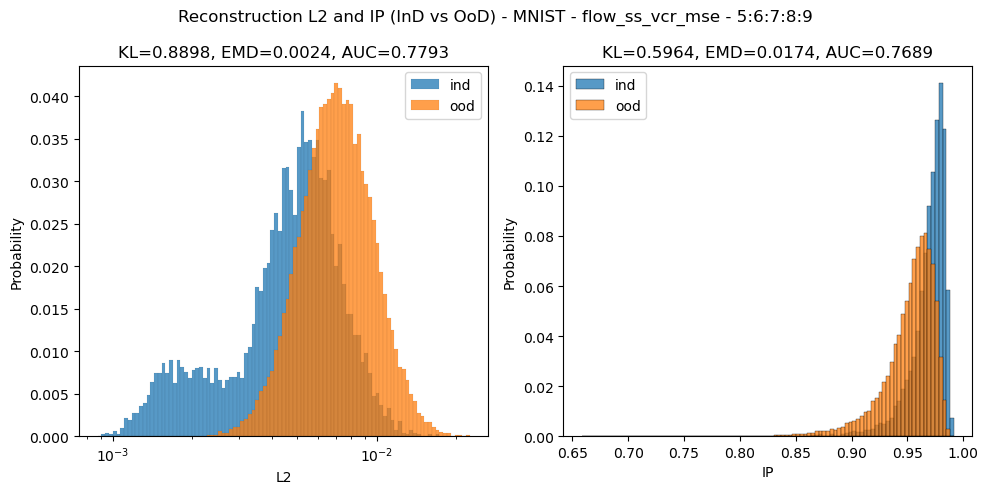

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

18.974598 1.675561 1.0916508 0.16052052
18.954294 1.644286 1.0940768 0.16482754
19.014482 1.7009993 1.0859902 0.16029623
18.475462 1.3169724 1.147889 0.14863192
33.816624 2.493169 24.853724 0.727023


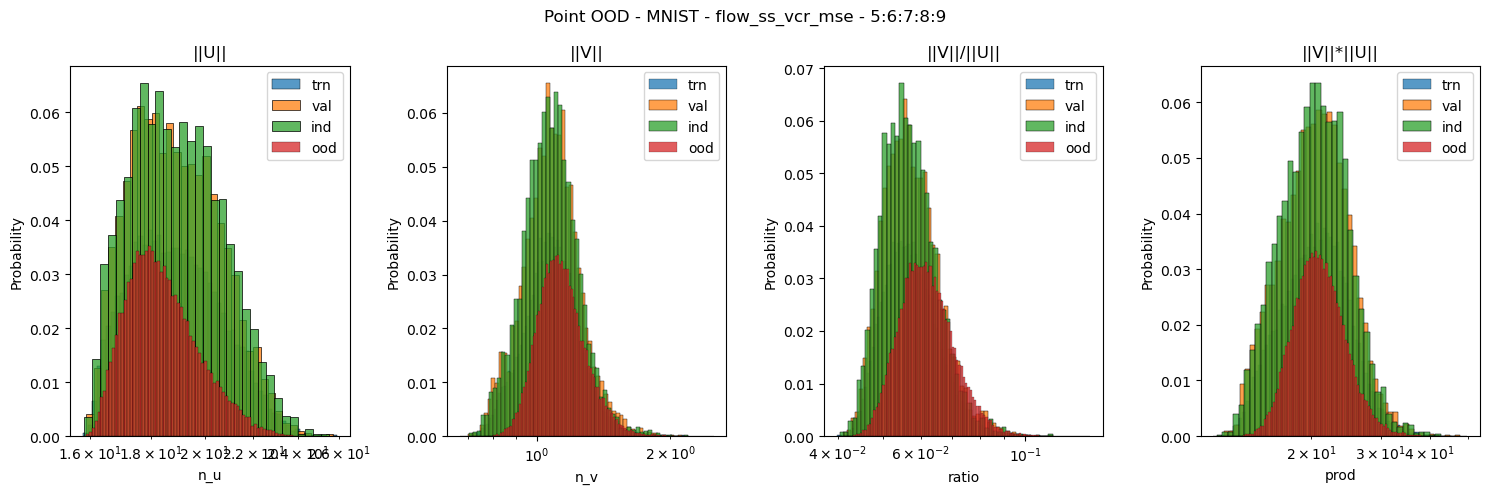

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


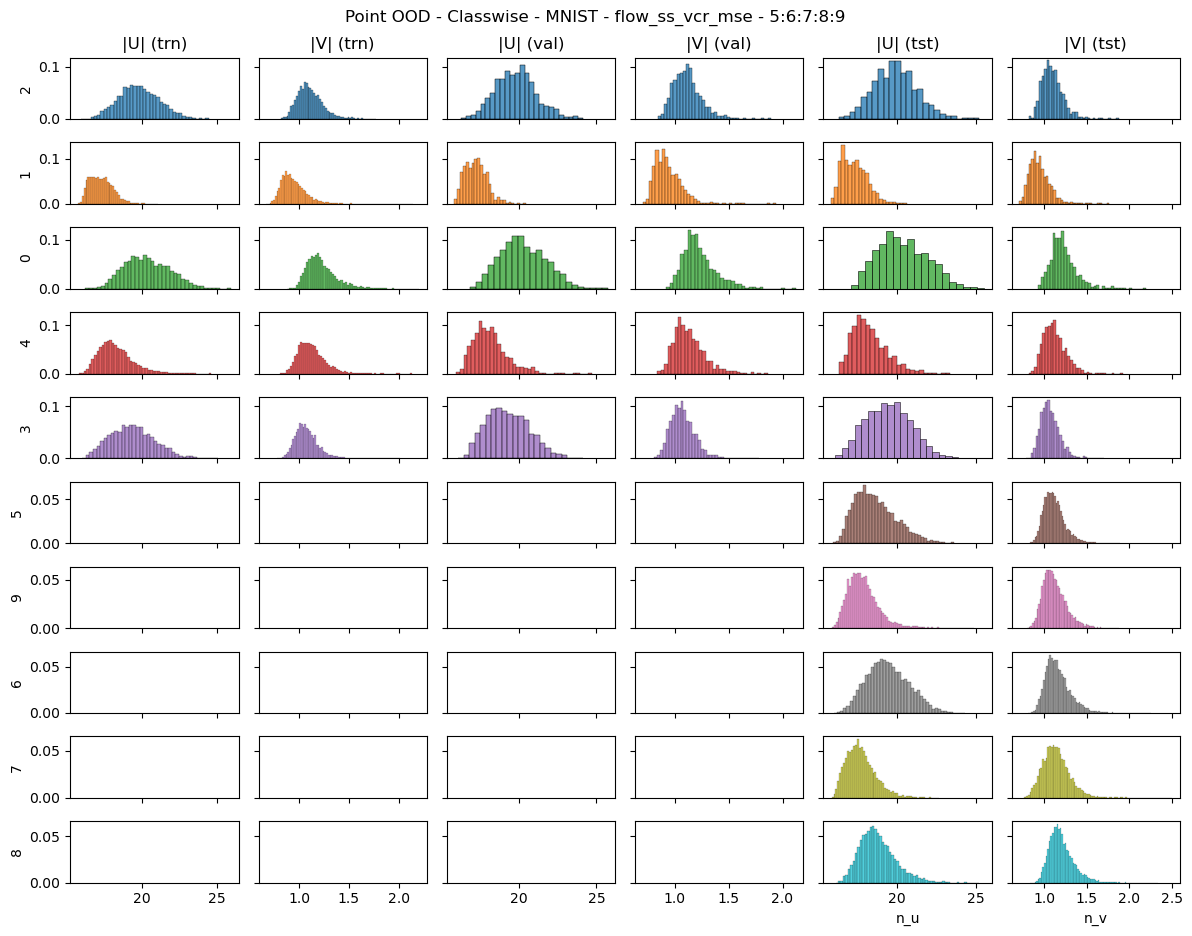

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

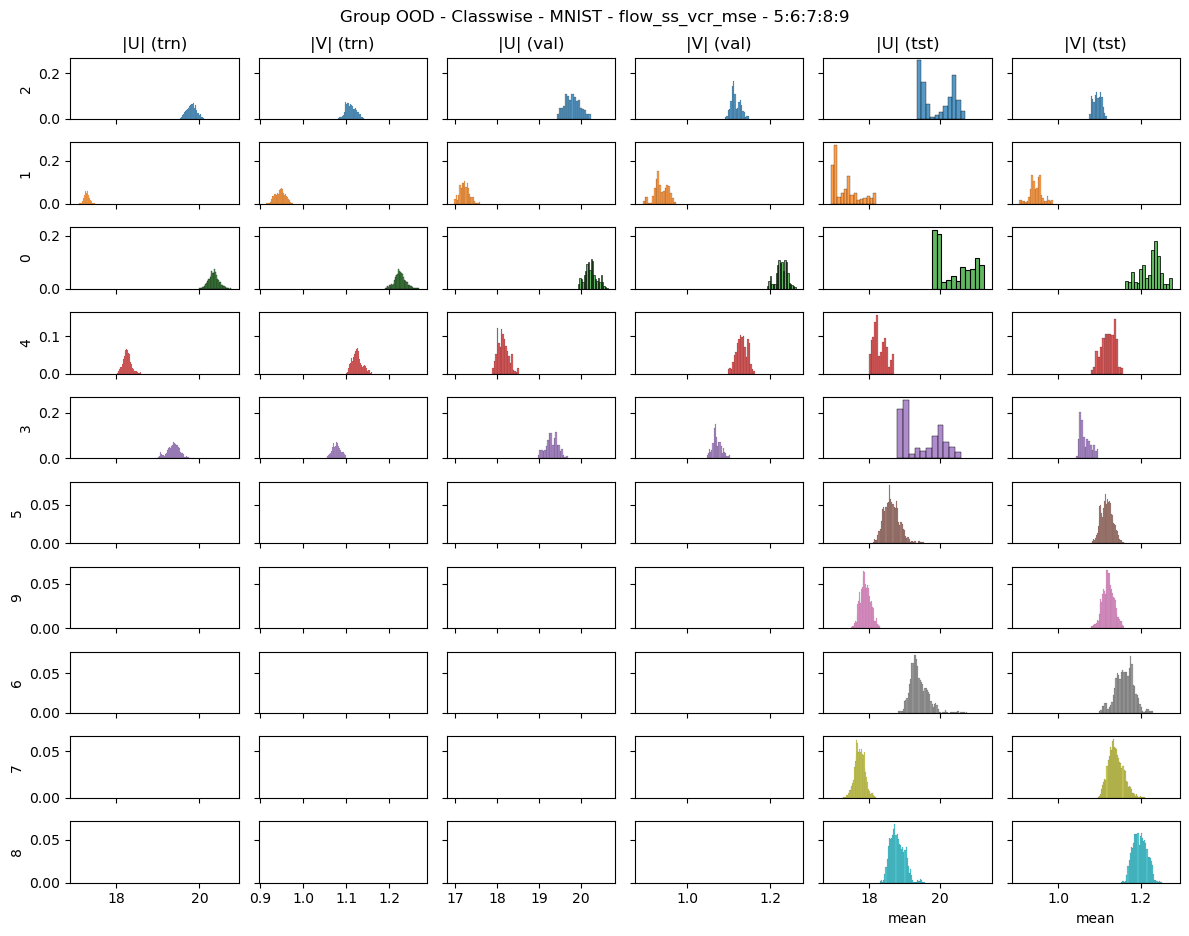

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)